## Includes

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import glob

# Latex results

In [4]:
results = [pd.read_csv(path) for path in glob.glob("../logs/*csv")]
results = pd.concat(results)
# Clean dataframe
results = results.apply(lambda x: x.apply(lambda y: y.split(' ')[1][:-1]))
results

,eeg_feature,model,hidden_channels,window_size,batch_size,learning_rate,dropout_rate,weight_decay,activation_funct,number_train_samples,...,val_f1,val_prec,val_reca,val_roc,pytorch_total_params,train_time,best_epoch,experiment_id,train_samples,val_samples
0,'wav','MLP',256,2.0,32,0.0005,0.25,0.0,'relu',2,...,0.9886212524465587,0.9898202470911872,0.98875,0.9999134072580644,41248,2000.7293481826782,599,'326','12,'22
1,'wav','MLP',256,2.0,32,0.0005,0.25,0.0,'relu',2,...,0.9906245125820113,0.9910835093068848,0.9906250000000001,0.9999359879032257,41248,2142.8056061267853,735,'1466','97,'52
2,'wav','MLP',256,2.0,32,0.0005,0.25,0.0,'relu',2,...,0.9823312199172278,0.9868760387797888,0.983125,0.9999946572580645,41248,3337.6750404834747,945,'2606','101,'11
3,'wav','MLP',256,2.0,32,0.0005,0.25,0.0,'relu',2,...,0.9924616192644403,0.9928560471732948,0.9925,0.999908870967742,41248,2653.7170102596283,925,'3746','5,'40
4,'wav','MLP',256,2.0,32,0.0005,0.25,0.0,'relu',2,...,0.9843726475297668,0.9868600780339203,0.985,0.9999833669354838,41248,2433.5561838150024,824,'4886','48,'40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,'wav','GraphConv',2048,2.0,32,0.0005,0.25,0.0,'relu',8,...,0.9827370966696336,0.982971402779677,0.9828125,0.999893245967742,329796,1861.271414756775,501,'6079','72,'101
6,'wav','GraphConv',2048,2.0,32,0.0005,0.25,0.0,'relu',8,...,0.9956257818003029,0.9956988325594605,0.995625,0.9999852822580645,329796,850.090039730072,206,'7219','59,'34
7,'wav','GraphConv',2048,2.0,32,0.0005,0.25,0.0,'relu',8,...,0.9956121781738663,0.995652035566702,0.995625,0.9999960685483871,329796,1379.2792975902557,295,'8359','28,'34
8,'wav','GraphConv',2048,2.0,32,0.0005,0.25,0.0,'relu',8,...,0.991193773041873,0.9914193086620109,0.99125,0.9999605846774193,329796,896.0295360088348,214,'9499','24,'8


In [5]:
model_names = ['GraphConv']
hidden_channels = [512, 1024]
models = list(filter(None, [f'{name}_{hc}' if not name == 'LR' else None if hc != 64 else 'LR' for name in model_names for hc in hidden_channels ]))
features = ['raw']
window_sizes = [1, 2]
number_train_samples = [16, 32, 64, 128]

In [6]:
sorted_by_time_nts_ws = np.array([ws*nts for ws in window_sizes for nts in number_train_samples])
b = np.array([ws for ws in window_sizes for nts in number_train_samples])
c = np.array([nts for ws in window_sizes for nts in number_train_samples])
idx = np.argsort(sorted_by_time_nts_ws)
sorted_by_time_nts_ws.sort()
sorted_ws = b[idx]
sorted_nts = c[idx]

In [7]:
dfs = []

for ef in features:
    print(ef)
    df = pd.DataFrame(index=models)
    for (ws,nts) in zip(sorted_ws, sorted_nts):
        res_col = []
        for model in models:
            if model == 'LR':
                hc = 0
            else:
                model, hc = model.split('_')
                hc = int(hc)
            res = results[(results['model'] == f'\'{model}\'') & (results['hidden_channels'].astype(int)==hc) & (results['window_size'].astype(float) == ws) & (results['number_train_samples'].astype(int)==nts) & (results['eeg_feature'] == f'\'{ef}\'')]
            mean_acc = res['test_acc'].astype(float).mean()
            std_acc = res['test_acc'].astype(float).std()

            res_col.append(f'{mean_acc:.2f}±{std_acc:.2f}')
        df[f'{ef} {ws}s x{nts}'] = res_col  
    dfs.append(df)

raw


In [9]:
raw_df = dfs[0]

# Inflection points

In [10]:
lr_res = raw_df.iloc[0]
lr_res

raw 1s x16     0.66±0.01
raw 1s x32     0.85±0.01
raw 2s x16     0.66±0.03
raw 1s x64     0.94±0.00
raw 2s x32     0.84±0.01
raw 1s x128    0.97±0.01
raw 2s x64     0.92±0.03
raw 2s x128    0.93±0.04
Name: GraphConv_512, dtype: object

## Option 1) Show all values

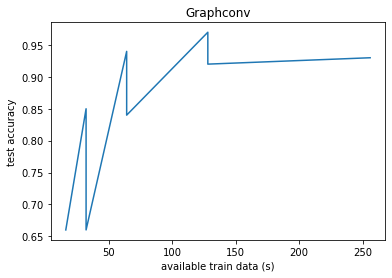

In [12]:
lr_means = np.array([float(x.split('±')[0]) for x in lr_res.to_numpy()])
lr_stds = np.array([float(x.split('±')[1]) for x in lr_res.to_numpy()])
plt.plot(sorted_by_time_nts_ws,lr_means)
plt.title('Graphconv')
plt.xlabel('available train data (s)')
plt.ylabel('test accuracy')
plt.show()

## Option 2) Merge values for x
https://www.researchgate.net/post/How_do_I_combine_mean_and_standard_deviation_of_two_groups

In [13]:
u_sorted_by_time_nts_ws = np.unique(sorted_by_time_nts_ws)
u_sorted_by_time_nts_ws

array([ 16,  32,  64, 128, 256])

In [14]:
merged_lr_res = []
for t in u_sorted_by_time_nts_ws:
    lr_res_time = lr_res[sorted_by_time_nts_ws==t]
    means = np.array([float(x.split('±')[0]) for x in lr_res_time.to_numpy()])
    stds = np.array([float(x.split('±')[1]) for x in lr_res_time.to_numpy()])
    merged_lr_res.append(f'{means.mean():.2f}±{stds.mean():.2f}')
merged_lr_res = pd.Series(data=merged_lr_res, index=u_sorted_by_time_nts_ws)
merged_lr_res

16     0.66±0.01
32     0.76±0.02
64     0.89±0.01
128    0.95±0.02
256    0.93±0.04
dtype: object

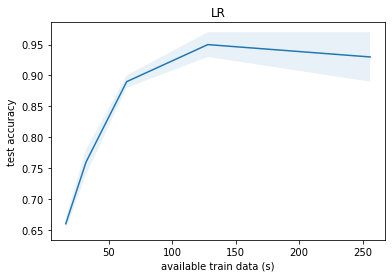

In [15]:
lr_means = np.array([float(x.split('±')[0]) for x in merged_lr_res.to_numpy()])
lr_stds = np.array([float(x.split('±')[1]) for x in merged_lr_res.to_numpy()])
plt.plot(u_sorted_by_time_nts_ws,lr_means)
plt.fill_between(u_sorted_by_time_nts_ws,lr_means-lr_stds,lr_means+lr_stds,alpha=.1)
plt.title('LR')
plt.xlabel('available train data (s)')
plt.ylabel('test accuracy')
plt.show()

# Create merged dfs

In [16]:
merged_dfs = []
for i,df in enumerate(dfs):
    merged_df_rows = []
    for row_id in range(len(df)):
        row_res = df.iloc[row_id]
        merged_row_res = []
        for t in u_sorted_by_time_nts_ws:
            raw_res_time = row_res[sorted_by_time_nts_ws==t]
            means = np.array([float(x.split('±')[0]) for x in raw_res_time.to_numpy()])
            stds = np.array([float(x.split('±')[1]) for x in raw_res_time.to_numpy()])
            merged_row_res.append(f'{means.mean():.2f}±{stds.mean():.2f}')
        # merged_row_res = pd.Series(data=merged_row_res, index=u_sorted_by_time_nts_ws)
        merged_df_rows.append(merged_row_res)
    merged_dfs.append(pd.DataFrame(merged_df_rows,index=models,columns=[f'{features[i]} {t} s.' for t in u_sorted_by_time_nts_ws]))

In [19]:
merged_raw_df= merged_dfs[0]

In [20]:
merged_raw_df

,raw 16 s.,raw 32 s.,raw 64 s.,raw 128 s.,raw 256 s.
GraphConv_512,0.66±0.01,0.76±0.02,0.89±0.01,0.95±0.02,0.93±0.04
GraphConv_1024,0.65±0.01,0.74±0.01,0.86±0.02,0.91±0.02,0.83±0.08


# Create latex tables for merged results

In [21]:
for i,f in enumerate(features):
    text_file = open(f'tables/{f}_table_res_merged.tex', "w")
    n = text_file.write(merged_dfs[i].to_latex(bold_rows=True))
    text_file.close()

In [24]:
models[0]

'GraphConv_512'

In [30]:
u_sorted_by_time_nts_ws,sorted_by_time_nts_ws

(array([ 16,  32,  64, 128, 256]),
 array([ 16,  32,  32,  64,  64, 128, 128, 256]))

In [31]:
df.shape[1]

8

# Plot both options side by side

[ 16  32  64 128 256]
[ 16  32  64 128 256]


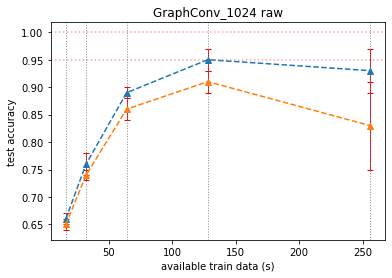

In [38]:
def show_inflection_point_graph(model_name, df, title):
    model_idx = np.where(df.index.to_numpy()==model_name)[0][0]
    res = df.iloc[model_idx]
    means = np.array([float(x.split('±')[0]) for x in res.to_numpy()])
    stds = np.array([float(x.split('±')[1]) for x in res.to_numpy()])
    x_axis = u_sorted_by_time_nts_ws if df.shape[1] == 5 else sorted_by_time_nts_ws
    print(x_axis)
   
    plt.errorbar(x_axis, means, stds, linestyle='--', marker='^',ecolor='red',elinewidth=1,capsize=3)
    plt.axhline(1, color='red',alpha=0.2,linestyle=':')
    plt.axhline(.95, color='red',alpha=0.2,linestyle=':')
#     plt.xticks(list(range(n_secs)))
    n_secs = int(x_axis.max()+1)
    for i in np.arange(0,n_secs,0.25):
#         if int(i) == i:
#             plt.axvline(i, color='gray',alpha=0.25,linestyle=':')
        if i in x_axis:
            plt.axvline(i, color='gray',alpha=0.55,linestyle=':',linewidth=1)
    
    plt.title(f'{title}')
    plt.xlabel('available train data (s)')
    plt.ylabel('test accuracy')

show_inflection_point_graph(models[0], merged_raw_df, f'{models[0]} raw')
show_inflection_point_graph(models[1], merged_raw_df, f'{models[1]} raw')
plt.show()

In [39]:
%%capture
from matplotlib.pyplot import figure
for i, (df,merged_df) in enumerate(zip(dfs,merged_dfs)):
    for model in models:
        figure(figsize=(20, 6), dpi=80)
        plt.subplot(1, 2, 1)
        show_inflection_point_graph(model, df, f'{model}({features[i]})')
        plt.subplot(1, 2, 2)
        show_inflection_point_graph(model, merged_df, f'{model} ({features[i]}) merged')
        plt.savefig(f'figures/{features[i]}_{model}.png')